In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms import community
import matplotlib.pyplot as plt
import seaborn as sns

/usr/lib/python3.9/site-packages/numpy/ma/core.py:4466: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.shape is ():


In [2]:
redlist = pd.read_csv("../../clean-redlist.csv")
redlist_lc = pd.read_csv("../../clean-redlist-least-concern.csv")
redlist = redlist.append(redlist_lc)
redlist = redlist.iloc[:, 1:]
redlist

,scientificName,redlistCategory,populationTrend,systems,realm,possiblyExtinct,possiblyExtinctInTheWild,longitude,latitude
0,hexanchus griseus,Near Threatened,Decreasing,Marine,NaN,False,False,NaN,NaN
1,heosemys annandalii,Critically Endangered,Decreasing,Terrestrial|Freshwater (=Inland waters),Indomalayan,False,False,NaN,NaN
2,hubbsina turneri,Critically Endangered,Decreasing,Freshwater (=Inland waters),Neotropical,False,False,"[-101.4795, -101.7773, -101.7876]","[19.8745, 19.8256, 19.8273]"
3,hungerfordia pelewensis,Endangered,Unknown,Terrestrial,Oceanian,False,False,NaN,NaN
4,ictalurus mexicanus,Vulnerable,Unknown,Freshwater (=Inland waters),Neotropical,False,False,"[-99.35417, -99.3]","[21.98083, 22.0]"
...,...,...,...,...,...,...,...,...,...
69144,myodes glareolus,Least Concern,Stable,Terrestrial,Palearctic,False,False,NaN,NaN
69145,neomys anomalus,Least Concern,Decreasing,Terrestrial|Freshwater (=Inland waters),Palearctic,False,False,NaN,NaN
69146,melanophylla alnifolia,Least Concern,Decreasing,Terrestrial,Afrotropical,False,False,"[46.38888, 47.23333, 47.26666, 47.2833333, 47....","[-23.46666, -18.15, -18.13333, -18.1783334, -1..."
69147,melanophylla aucubifolia,Least Concern,Decreasing,Terrestrial,Afrotropical,False,False,"[46.39388, 46.53333, 46.54222, 46.89833, 47.00...","[-23.47055, -23.54055, -23.5325, -22.42166, -2..."


In [3]:
interactions = pd.read_csv('../../clean-interactions.csv')
interactions

,sourceTaxonSpeciesName,sourceTaxonKingdomName,interactionTypeName,targetTaxonSpeciesName,targetTaxonKingdomName
0,andrena milwaukeensis,Animalia,visitsFlowersOf,zizia aurea,Plantae
1,andrena mandibularis,Animalia,visitsFlowersOf,zanthoxylum americanum,Plantae
2,andrena edwardsi,Animalia,visitsFlowersOf,wyethia mollis,Plantae
3,andrena mandibularis,Animalia,visitsFlowersOf,viburnum dentatum,Plantae
4,andrena milwaukeensis,Animalia,visitsFlowersOf,viburnum lentago,Plantae
...,...,...,...,...,...
899700,calyptra orthograpta,Animalia,eats,bubalus bubalis,Animalia
899701,calyptra orthograpta,Animalia,eats,cervus unicolor,Animalia
899702,calyptra orthograpta,Animalia,eats,elephas maximus,Animalia
899703,calyptra pseudobicolor,Animalia,eats,homo sapiens,Animalia


In [4]:
# Select entries only in the intersection of both datasets
species = redlist['scientificName']
filter_interactions = interactions[
    interactions['sourceTaxonSpeciesName'].isin(species) &
    interactions['targetTaxonSpeciesName'].isin(species)
]
species = set(filter_interactions['sourceTaxonSpeciesName']) | set(filter_interactions['targetTaxonSpeciesName'])
filter_redlist = redlist[redlist['scientificName'].isin(species)]
print(len(filter_redlist), len(filter_interactions))

13240 91143


In [5]:
graph = nx.from_pandas_edgelist(filter_interactions, 'sourceTaxonSpeciesName', 'targetTaxonSpeciesName')
print(len(graph.nodes), len(graph.edges))

12949 78790


In [6]:
# Select only the largest connected component (>90% of species, >98% of interactions)
sp_largest_component = sorted(nx.algorithms.components.connected_components(graph), key=len, reverse=True)[0]
filter_redlist = filter_redlist[filter_redlist['scientificName'].isin(sp_largest_component)]
filter_interactions = filter_interactions[
    filter_interactions['sourceTaxonSpeciesName'].isin(sp_largest_component) &
    filter_interactions['targetTaxonSpeciesName'].isin(sp_largest_component)
]
graph = nx.from_pandas_edgelist(filter_interactions, 'sourceTaxonSpeciesName', 'targetTaxonSpeciesName')
print(len(filter_redlist), len(filter_interactions))

12458 89957


In [7]:
def is_threatened(df):
    return 1 - df.redlistCategory.isin(['Least Concern', 'Near Threatened'])
filter_redlist = filter_redlist.assign(threatened=is_threatened(filter_redlist))
threat_redlist = filter_redlist[filter_redlist.threatened == 1]
no_threat_redlist = filter_redlist[filter_redlist.threatened != 1]
global_threat_prop = len(threat_redlist) / len(filter_redlist)
1/global_threat_prop

8.288755821689954

In [8]:
# Export to gephi
#threatened_dict = {sp.scientificName: sp.threatened for sp in filter_redlist.itertuples()}
#nx.set_node_attributes(graph, threatened_dict, 'threatened')
#nx.write_gexf(graph, 'interactions.gexf')

In [9]:
# Calculate communities using a label propagation algorithm
#comms1 = list(community.label_propagation.asyn_lpa_communities(graph))

#print(f'community count: {len(comms1)}')
#print(f'average community size: {sum(map(len, comms1)) / len(comms1)}')
#print(f'example: {comms1[200]}')
#print(f'len examples: {len(comms1[0])}, {len(comms1[1])}, {len(comms1[2])}, {len(comms1[3])}')
#ax = sns.histplot(data=[len(c) for c in comms1], binwidth=1, binrange=(2,100))
#ax.set_yscale('log')

In [10]:
# Other community extraction algorithms for comparison
# comm_gen2 = community.modularity_max.greedy_modularity_communities(graph)
# comms2 = list(comm_gen2)
# print(f'community count: {len(comms2)}')
# print(f'average community size: {sum(map(len, comms2)) / len(comms2)}')
# ax = sns.histplot(data=[len(c) for c in comms2], binwidth=1, binrange=(2,100))
# ax.set_yscale('log')
# plt.show()

community count: 841
average community size: 14.474435196195007


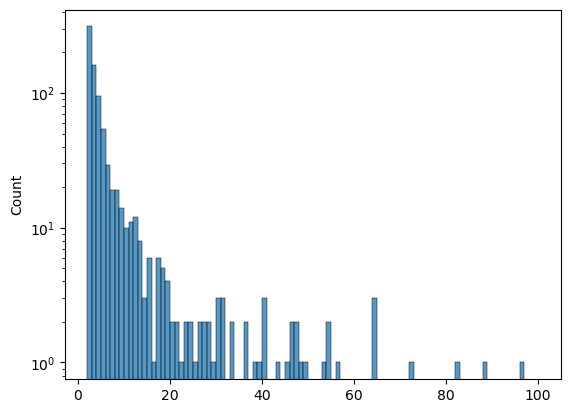

In [11]:
comms3 = list(community.label_propagation.label_propagation_communities(graph))
print(f'community count: {len(comms3)}')
print(f'average community size: {sum(map(len, comms3)) / len(comms3)}')
ax = sns.histplot(data=[len(c) for c in comms3], binwidth=1, binrange=(2,100))
ax.set_yscale('log')
plt.show()

In [12]:
# This one is extremely slow
#comms4 = list(community.centrality.girvan_newman(graph))
#print(f'community count: {len(comms4)}')
#print(f'average community size: {sum(map(len, comms4)) / len(comms4)}')
#ax = sns.histplot(data=[len(c) for c in comms4], binwidth=1, binrange=(2,100))
#ax.set_yscale('log')

In [13]:
# Selecting which algorithm to use
comms = comms3

In [14]:
# Filter only large communities
# 2 for all communities
size_threshold = 2
big_comms = [c for c in comms if len(c) >= size_threshold]
communities_df = [filter_redlist[filter_redlist['scientificName'].isin(c)] for c in big_comms]
print(f'species removed: <{100*(len(comms)-len(big_comms))*size_threshold/len(filter_redlist):.2f}%')
print(f'remaining community count: {len(big_comms)}')
print(f'avg big community size: {sum(map(len, big_comms)) / len(big_comms):.2f}')

species removed: <0.00%
remaining community count: 841
avg big community size: 14.47


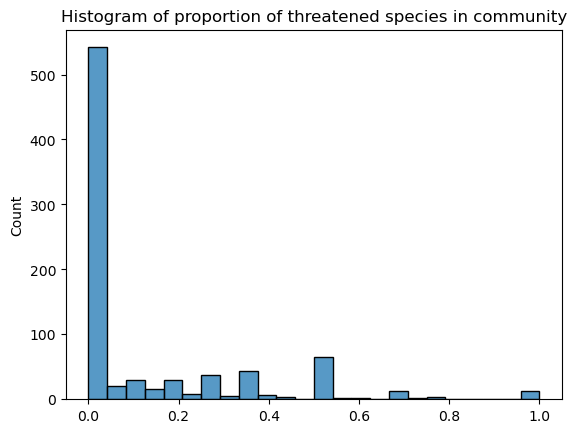

In [15]:
threatened_proportion = [is_threatened(df).mean() for df in communities_df]
ax = sns.histplot(threatened_proportion)
_ = ax.set(title='Histogram of proportion of threatened species in community')
plt.show()

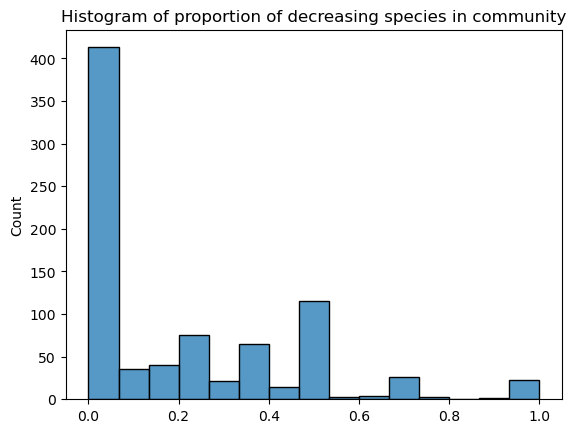

In [16]:
decreasing_proportion = [(df.populationTrend == 'Decreasing').mean() for df in communities_df]
ax = sns.histplot(decreasing_proportion)
_ = ax.set(title='Histogram of proportion of decreasing species in community')
plt.show()

In [17]:
# ax = sns.histplot(data=filter_redlist, x='redlistCategory')
# _ = ax.set(title='Species count by category')
# _ = plt.xticks(rotation=90)

In [18]:
# dec_count_df = filter_redlist[filter_redlist.populationTrend == 'Decreasing']
# ax = sns.histplot(dec_count_df, x='redlistCategory')
# _ = ax.set(title='Decreasing species count by category')
# _ = plt.xticks(rotation=90)

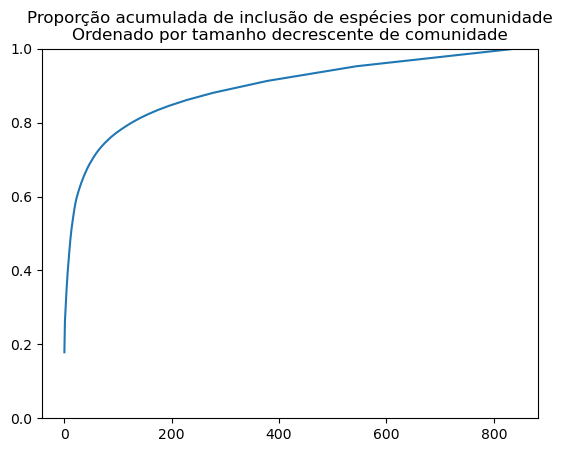

In [19]:
accum_comm = np.add.accumulate(sorted([len(c) for c in communities_df], reverse=True))
ax = sns.lineplot(data=accum_comm/len(filter_redlist))
_ = ax.set(title='Proporção acumulada de inclusão de espécies por comunidade\nOrdenado por tamanho decrescente de comunidade')
_ = ax.set_ylim(0, 1)
plt.show()

In [20]:
sorted_communities = sorted(communities_df, key=len, reverse=True)
def get_community_idx(node):
    for i, comm in enumerate(sorted_communities):
        if node in set(comm.scientificName):
            return i

In [21]:
# n_comms = 10
# graph_sp = set()
# for comm in sorted_communities[:n_comms]:
#     graph_sp |= set(comm.scientificName)

# graph_inter = interactions[
#     interactions.sourceTaxonSpeciesName.isin(graph_sp) &
#     interactions.targetTaxonSpeciesName.isin(graph_sp)
# ]
# graph_d = nx.from_pandas_edgelist(
#     filter_interactions,
#     'sourceTaxonSpeciesName',
#     'targetTaxonSpeciesName')
# print(len(graph_sp), len(graph_d.edges))

In [22]:
# degree_centrality = nx.degree_centrality(graph_d) # Calcula o tamanho dos nós com base na quantidade de conexões que cada um tem
# nx.set_node_attributes(graph_d, degree_centrality, 'degree_centr')
# node_sizes = [v * 100000 for v in degree_centrality.values()]

In [23]:
# community_idxs = [get_community_idx(node) for node in graph_d.nodes]

In [24]:
# n_colors = 10
# colors = [min(idx, n_colors-1) for idx in community_idxs]

In [25]:
# pos = nx.spring_layout(graph_d, k=0.03) # Calcula as posições onde os nós serão exibidos

In [26]:
# plt.figure(figsize=(15, 15))
# nx.draw(
#     graph_d,
#     pos=pos,
#     node_size=node_sizes,
#     #node_size=100,
#     node_color=colors,
#     edge_color=(0.1,0.1,0.1),
#     alpha=0.4,
#     with_labels=False)

In [27]:
# Calculate some community information
def get_community_stats(communities_df):
    comm_stats = []
    for c in communities_df:
        comm_size = len(c)
        comm_size_others = comm_size - 1
        c_threat = is_threatened(c)
        threat_count = c_threat.sum()
#         c_dec = c.populationTrend == 'Decreasing'
#         dec_count = c_dec.sum()
        for sp in c.itertuples():
            threat_count_others = threat_count - int(sp.redlistCategory not in ('Least Concern', 'Near Threatened'))
            threat_prop = threat_count_others / comm_size_others
            threat_prev = threat_prop / global_threat_prop
#             dec_count_others = dec_count - int(sp.populationTrend == 'Decreasing')
#             c_same_cat = c.redlistCategory == (c[c.scientificName == sp.scientificName].iloc[0].redlistCategory)
#             same_cat_count = c_same_cat.sum() - 1
            comm_stats.append({
                'scientificName': sp.scientificName,
                'redlistCategory': sp.redlistCategory,
                'commSize': comm_size,
                'threatCount': threat_count_others,
                'threatProp': threat_prop,
                'threatPrev': threat_prev,
                'threatAny': threat_count_others != 0,
                'threatAll': threat_count_others == comm_size_others,
                'threatMaj': (threat_count_others / comm_size_others) >= 0.5,
                'threatPrevMaj': threat_prev >= 1,
#                 'sameCatCount': same_cat_count,
#                 'sameCatAny': same_cat_count != 0,
#                 'sameCatAll': same_cat_count == comm_size_others,
#                 'sameCatProp': same_cat_count / comm_size_others,
#                 'sameCatMaj': (same_cat_count / comm_size_others) >= 0.5,
#                 'decCount': dec_count_others,
#                 'decAny': dec_count_others != 0,
#                 'decAll': dec_count_others == comm_size_others,
#                 'decProp': dec_count_others / comm_size_others,
#                 'decMaj': (dec_count_others / comm_size_others) >= 0.5,
            })
    comm_stats = pd.DataFrame(comm_stats)
    comm_stats = comm_stats.assign(threatened=is_threatened(comm_stats))
    return comm_stats
comm_stats = get_community_stats(communities_df)
comm_stats

,scientificName,redlistCategory,commSize,threatCount,threatProp,threatPrev,threatAny,threatAll,threatMaj,threatPrevMaj,threatened
0,marrubium vulgare,Near Threatened,295,21,0.071429,0.592054,True,False,False,False,0
1,lycaena dispar,Lower Risk/near threatened,295,20,0.068027,0.563861,True,False,False,False,1
2,panoquina errans,Lower Risk/near threatened,295,20,0.068027,0.563861,True,False,False,False,1
3,eryngium alpinum,Near Threatened,295,21,0.071429,0.592054,True,False,False,False,0
4,ipomoea sagittata,Vulnerable,295,20,0.068027,0.563861,True,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...
12453,eriochloa procera,Least Concern,3,0,0.000000,0.000000,False,False,False,False,0
12454,francolinus francolinus,Least Concern,3,0,0.000000,0.000000,False,False,False,False,0
12455,clathrotropis brachypetala,Least Concern,3,0,0.000000,0.000000,False,False,False,False,0
12456,amazilia brevirostris,Least Concern,3,0,0.000000,0.000000,False,False,False,False,0


In [28]:
cat_comm_stats = comm_stats.pivot_table(
    index='redlistCategory',
    #values='commSize threatCount threatAny threatAll threatProp threatMaj sameCatCount sameCatAny sameCatAll sameCatProp sameCatMaj decCount decAny decAll decProp decMaj'\
    values='commSize threatCount threatProp threatPrev threatAny threatAll threatMaj threatPrevMaj'\
        .split(),
    aggfunc=np.mean
)
cat_comm_stats

,commSize,threatAll,threatAny,threatCount,threatMaj,threatPrev,threatPrevMaj,threatProp
redlistCategory,,,,,,,,
Critically Endangered,518.902062,0.036082,0.886598,68.809278,0.087629,1.853842,0.536082,0.223657
Endangered,526.967249,0.019651,0.858079,66.085153,0.056769,1.564400,0.471616,0.188738
Extinct,822.473684,0.000000,1.000000,98.105263,0.052632,1.806359,0.473684,0.217929
Extinct in the Wild,744.000000,0.333333,1.000000,87.666667,0.666667,4.467236,0.666667,0.538951
Least Concern,572.366335,0.006091,0.803345,63.505076,0.016920,0.889513,0.223823,0.107316
Lower Risk/conservation dependent,346.200000,0.000000,0.933333,35.133333,0.066667,1.384570,0.400000,0.167042
Lower Risk/least concern,437.894737,0.017544,0.929825,45.789474,0.105263,1.901858,0.526316,0.229450
Lower Risk/near threatened,489.456522,0.043478,0.956522,52.586957,0.152174,1.831114,0.391304,0.220915
Near Threatened,609.782680,0.006536,0.892157,74.395425,0.026144,1.368027,0.434641,0.165046


In [29]:
threat_comm_stats = comm_stats.pivot_table(
    index='threatened',
    #values='commSize threatCount threatAny threatAll threatProp threatMaj sameCatCount sameCatAny sameCatAll sameCatProp sameCatMaj decCount decAny decAll decProp decMaj'\
    values='commSize threatCount threatProp threatPrev threatAny threatAll threatMaj threatPrevMaj'\
        .split(),
    aggfunc=np.mean
)
threat_comm_stats

,commSize,threatAll,threatAny,threatCount,threatMaj,threatPrev,threatPrevMaj,threatProp
threatened,,,,,,,,
0,574.456595,0.006116,0.808307,64.113464,0.017435,0.916245,0.235600,0.110541
1,534.838323,0.017964,0.888889,66.530938,0.061876,1.610471,0.468397,0.194296


Uma espécie é ameaçada se tem classificação `Vulnerable` ou pior

### Comparando com interações diretamente

In [30]:
def get_interaction_per_species(interactions, species, depth=1):
    sp_interactions = {sp:set() for sp in set(species.scientificName)}
    for inter in interactions.itertuples():
        sp_interactions[inter.sourceTaxonSpeciesName].add(inter.targetTaxonSpeciesName)
        sp_interactions[inter.targetTaxonSpeciesName].add(inter.sourceTaxonSpeciesName)

    for _ in range(depth-1):
        new_sp_interactions = {sp:set() for sp in set(species.scientificName)}
        for sp_name, sp_inter in sp_interactions.items():
            for other_sp in sp_inter:
                new_sp_interactions[sp_name] |= sp_interactions[other_sp]
        sp_interactions = new_sp_interactions
    sp_interactions = {
        sp_name: species[species.scientificName.isin(sp_inter)]
        for sp_name, sp_inter in sp_interactions.items()}
    return sp_interactions
sp_interactions = get_interaction_per_species(filter_interactions, filter_redlist, depth=1)

In [31]:
sp_interactions_d2 = get_interaction_per_species(filter_interactions, filter_redlist, depth=2)

In [32]:
sp_interactions_d3 = get_interaction_per_species(filter_interactions, filter_redlist, depth=3)

In [33]:
def get_interaction_stats(interactions_per_species, species):
    inter_stats = []
    for sp_name, sp_inter in interactions_per_species.items():
        sp = species[species.scientificName == sp_name].iloc[0]
        inter_count = len(sp_inter)
        inter_threat = is_threatened(sp_inter)
        threat_count = inter_threat.sum()
        threat_prop = threat_count / inter_count
        threat_prev = threat_prop / global_threat_prop
#         inter_dec = sp_inter.populationTrend == 'Decreasing'
#         dec_count = inter_dec.sum()
#         inter_same_cat = sp_inter.redlistCategory == sp.redlistCategory
#         same_cat_count = inter_same_cat.sum()
        inter_stats.append({
            'scientificName': sp.scientificName,
            'redlistCategory': sp.redlistCategory,
            'interCount': inter_count,
            'threatCount': threat_count,
            'threatProp': threat_prop,
            'threatPrev': threat_prev,
            'threatAny': threat_count != 0,
            'threatAll': threat_count == inter_count,
            'threatMaj': (threat_count / inter_count) >= 0.5,
            'threatPrevMaj': threat_prev >= 1,
#             'sameCatCount': same_cat_count,
#             'sameCatAny': same_cat_count != 0,
#             'sameCatAll': same_cat_count == inter_count,
#             'sameCatProp': same_cat_count / inter_count,
#             'sameCatMaj': (same_cat_count / inter_count) >= 0.5,
#             'decCount': dec_count,
#             'decAny': dec_count != 0,
#             'decAll': dec_count == inter_count,
#             'decProp': dec_count / inter_count,
#             'decMaj': (dec_count / inter_count) >= 0.5,
        })
    inter_stats = pd.DataFrame(inter_stats)
    inter_stats = inter_stats.assign(threatened=is_threatened(inter_stats))
    return inter_stats

In [34]:
inter_stats1 = get_interaction_stats(sp_interactions, filter_redlist)
threat_inter_stats1 = inter_stats1.pivot_table(
    index='threatened',
    #values='interCount threatCount threatAny threatAll threatProp threatMaj sameCatCount sameCatAny sameCatAll sameCatProp sameCatMaj decCount decAny decAll decProp decMaj'\
    values='interCount threatCount threatProp threatPrev threatAny threatAll threatMaj threatPrevMaj'\
        .split(),
    aggfunc=np.mean
)
threat_inter_stats1

,interCount,threatAll,threatAny,threatCount,threatMaj,threatPrev,threatPrevMaj,threatProp
threatened,,,,,,,,
0,13.478696,0.049833,0.402464,1.290107,0.104668,1.071728,0.257595,0.129299
1,10.613653,0.106028,0.469862,1.672476,0.180828,1.711658,0.366013,0.206504


In [35]:
inter_stats2 = get_interaction_stats(sp_interactions_d2, filter_redlist)
threat_inter_stats2 = inter_stats2.pivot_table(
    index='threatened',
    #values='interCount threatCount threatAny threatAll threatProp threatMaj sameCatCount sameCatAny sameCatAll sameCatProp sameCatMaj decCount decAny decAll decProp decMaj'\
    values='interCount threatCount threatProp threatPrev threatAny threatAll threatMaj threatPrevMaj'\
        .split(),
    aggfunc=np.mean
)
threat_inter_stats2

,interCount,threatAll,threatAny,threatCount,threatMaj,threatPrev,threatPrevMaj,threatProp
threatened,,,,,,,,
0,215.657280,0.000000,0.827066,21.814839,0.007132,0.787271,0.283346,0.094981
1,181.754539,0.006536,1.000000,30.704430,0.076979,1.779666,0.657952,0.214708


In [36]:
inter_stats3 = get_interaction_stats(sp_interactions_d3, filter_redlist)
threat_inter_stats3 = inter_stats3.pivot_table(
    index='threatened',
    #values='interCount threatCount threatAny threatAll threatProp threatMaj sameCatCount sameCatAny sameCatAll sameCatProp sameCatMaj decCount decAny decAll decProp decMaj'\
    values='interCount threatCount threatProp threatPrev threatAny threatAll threatMaj threatPrevMaj'\
        .split(),
    aggfunc=np.mean
)
threat_inter_stats3

,interCount,threatAll,threatAny,threatCount,threatMaj,threatPrev,threatPrevMaj,threatProp
threatened,,,,,,,,
0,4161.913672,0.0,0.990923,494.734624,0.000093,0.964648,0.439700,0.11638
1,4043.344953,0.0,1.000000,500.096587,0.004357,1.067015,0.560639,0.12873


In [37]:
cat_inter_stats1 = inter_stats1.pivot_table(
    index='redlistCategory',
    #values='interCount threatCount threatAny threatAll threatProp threatMaj sameCatCount sameCatAny sameCatAll sameCatProp sameCatMaj decCount decAny decAll decProp decMaj'\
    values='interCount threatCount threatProp threatPrev threatAny threatAll threatMaj threatPrevMaj'\
        .split(),
    aggfunc=np.mean
)
cat_inter_stats1

,interCount,threatAll,threatAny,threatCount,threatMaj,threatPrev,threatPrevMaj,threatProp
redlistCategory,,,,,,,,
Critically Endangered,9.573171,0.128049,0.439024,1.530488,0.170732,1.667542,0.323171,0.201181
Endangered,9.570755,0.099057,0.438679,1.443396,0.169811,1.580587,0.334906,0.190690
Extinct,4.315789,0.105263,0.473684,1.052632,0.210526,1.991154,0.473684,0.240224
Extinct in the Wild,5.000000,0.000000,0.666667,1.333333,0.333333,2.578724,0.666667,0.311111
Least Concern,13.544637,0.049281,0.400411,1.265963,0.102669,1.057674,0.254033,0.127603
Lower Risk/conservation dependent,8.133333,0.133333,0.733333,1.466667,0.266667,2.842943,0.666667,0.342988
Lower Risk/least concern,15.500000,0.250000,0.625000,2.035714,0.321429,2.934778,0.535714,0.354067
Lower Risk/near threatened,7.860465,0.209302,0.604651,1.325581,0.279070,2.593002,0.511628,0.312834
Near Threatened,12.293497,0.059754,0.439367,1.724077,0.140598,1.324328,0.321617,0.159774


In [38]:
aggr = threat_comm_stats.append(threat_inter_stats1)
aggr = aggr.append(threat_inter_stats2)
aggr = aggr.append(threat_inter_stats3)
aggr

,commSize,threatAll,threatAny,threatCount,threatMaj,threatPrev,threatPrevMaj,threatProp,interCount
threatened,,,,,,,,,
0,574.456595,0.006116,0.808307,64.113464,0.017435,0.916245,0.235600,0.110541,NaN
1,534.838323,0.017964,0.888889,66.530938,0.061876,1.610471,0.468397,0.194296,NaN
0,NaN,0.049833,0.402464,1.290107,0.104668,1.071728,0.257595,0.129299,13.478696
1,NaN,0.106028,0.469862,1.672476,0.180828,1.711658,0.366013,0.206504,10.613653
0,NaN,0.000000,0.827066,21.814839,0.007132,0.787271,0.283346,0.094981,215.657280
1,NaN,0.006536,1.000000,30.704430,0.076979,1.779666,0.657952,0.214708,181.754539
0,NaN,0.000000,0.990923,494.734624,0.000093,0.964648,0.439700,0.116380,4161.913672
1,NaN,0.000000,1.000000,500.096587,0.004357,1.067015,0.560639,0.128730,4043.344953


### Analisando comunidades e interações por região

In [ ]:
realm_set = set(filter_redlist.realm.astype(str))
realms = set()
for realm in realm_set:
    realm = set(realm.split('|'))
    realms |= realm
realms

In [ ]:
redlist_realms = {}
interaction_realms = {}
for realm in realms:
    realm_species = filter_redlist[filter_redlist.realm.astype(str).str.contains(realm)]
    redlist_realms[realm] = realm_species
    species = set(realm_species.scientificName)
    realm_interactions = filter_interactions[
        filter_interactions['sourceTaxonSpeciesName'].isin(species) &
        filter_interactions['targetTaxonSpeciesName'].isin(species)]
    interaction_realms[realm] = realm_interactions
redlist_realms['Neotropical']